## Data Analysis and Preparation

### Import libraries

In [1]:
import os
import pandas as pd
import tensorflow as tf
import tensorflow_data_validation as tfdv
from google.cloud import bigquery
import matplotlib.pyplot as plt

from google.cloud import aiplatform as vertex_ai

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import yaml

# Load YAML configuration file
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

### Configurations

In [3]:
PROJECT = config['project']
REGION = config['region']

BQ_DATASET_NAME = config['bq_dataset_name']
BQ_TABLE_NAME = config['bq_table_name']
BQ_LOCATION = config['bq_location']

DATASET_DISPLAY_NAME = config['dataset_display_name']

RAW_SCHEMA_DIR = config['raw_schema_dir']

## EDA

In [5]:
%load_ext google.cloud.bigquery

In [6]:
# Run the BigQuery query
from google.cloud import bigquery

client = bigquery.Client()

query = """
SELECT 
    CAST(EXTRACT(DAYOFWEEK FROM trip_start_timestamp) AS string) AS trip_dayofweek, 
    FORMAT_DATE('%A', CAST(trip_start_timestamp AS DATE)) AS trip_dayname,
    COUNT(*) AS trip_count
FROM `pa-poc-mlspec-1.chicago_taxi_trips.taxi_trips`
WHERE EXTRACT(YEAR FROM trip_start_timestamp) = 2015 
GROUP BY trip_dayofweek, trip_dayname
ORDER BY trip_dayofweek
"""

# Run the query and convert to a pandas DataFrame
df = client.query(query).to_dataframe()


c:\Users\MANSM\Demo\GCPML-ChicagoTaxi\.venv\lib\site-packages\google\cloud\bigquery\table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\MANSM\Demo\GCPML-ChicagoTaxi\.venv\lib\site-packages\google\cloud\bigquery\table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\MANSM\Demo\GCPML-ChicagoTaxi\.venv\lib\site-packages\google\cloud\bigquery\table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


<Axes: xlabel='trip_dayname'>

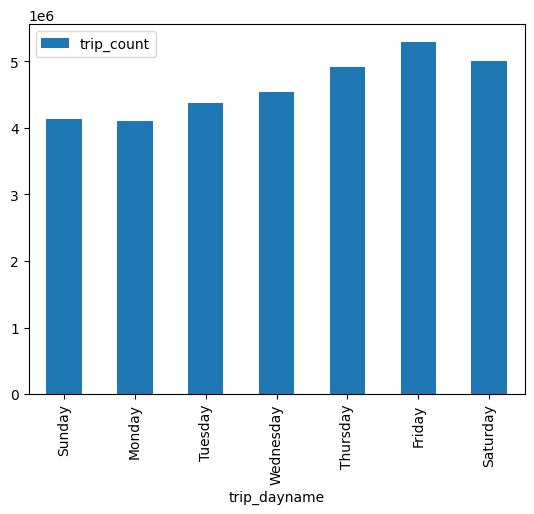

In [7]:
df.plot(kind='bar', x='trip_dayname', y='trip_count')

### Create destination BigQuery dataset

In [8]:
!bq --location=$BQ_LOCATION mk -d \
$PROJECT:$BQ_DATASET_NAME

BigQuery error in mk operation: Dataset 'pa-poc-mlspec-1:playground' already
exists.


In [9]:
sample_size = 1000000
year = 2020
sql_script = config["sql_script"]

In [11]:
sql_script = sql_script.replace(
    '@PROJECT', PROJECT).replace(
    '@DATASET', BQ_DATASET_NAME).replace(
    '@TABLE', BQ_TABLE_NAME).replace(
    '@YEAR', str(year)).replace(
    '@LIMIT', str(sample_size))

In [12]:
bq_client = bigquery.Client(project=PROJECT, location=BQ_LOCATION)
job = bq_client.query(sql_script)
_ = job.result()

In [18]:
%%bigquery --project {PROJECT}

SELECT dropoff_community_area, community_name,
SUM(total_arrests) AS total_arrests
FROM playground.taxi_trips 
GROUP BY dropoff_community_area, community_name

Query is running:   0%|          |

c:\Users\MANSM\Demo\GCPML-ChicagoTaxi\.venv\lib\site-packages\google\cloud\bigquery\table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\MANSM\Demo\GCPML-ChicagoTaxi\.venv\lib\site-packages\google\cloud\bigquery\table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\MANSM\Demo\GCPML-ChicagoTaxi\.venv\lib\site-packages\google\cloud\bigquery\table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


Downloading:   0%|          |

,dropoff_community_area,community_name,total_arrests
0,24,West Town,171118392
1,51,South Deering,2233401
2,76,O'Hare,30021435
3,28,Near West Side,746036100
4,33,Near South Side,47299142
...,...,...,...
73,57,Archer Heights,265490
74,45,Avalon Park,1297257
75,55,Hegewisch,80264
76,54,Riverdale,432822


### Load a sample data to a Pandas DataFrame

In [8]:
%%bigquery df --project {PROJECT}

SELECT * EXCEPT (trip_start_timestamp)
FROM playground.taxi_trips 

Query is running:   0%|          |

c:\Users\MANSM\Demo\GCPML-ChicagoTaxi\.venv\lib\site-packages\google\cloud\bigquery\table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\MANSM\Demo\GCPML-ChicagoTaxi\.venv\lib\site-packages\google\cloud\bigquery\table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\MANSM\Demo\GCPML-ChicagoTaxi\.venv\lib\site-packages\google\cloud\bigquery\table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


Downloading:   0%|          |

In [9]:
df.head().T

,0,1,2,3,4
trip_month,2,2,10,12,2
trip_day,18,18,10,27,23
trip_day_of_week,3,3,7,1,1
trip_hour,9,9,14,10,5
trip_seconds,2150,2106,37,44,1436
trip_miles,16.45,16.44,0.01,0.03,21.6
payment_type,Cash,Cash,Cash,Cash,Cash
pickup_grid,POINT(-87.6 41.7),POINT(-87.6 41.7),POINT(-87.6 41.7),POINT(-87.6 41.7),POINT(-87.6 41.8)
dropoff_grid,POINT(-87.7 41.9),POINT(-87.7 41.9),POINT(-87.6 41.7),POINT(-87.6 41.7),POINT(-87.9 42)
euclidean,21321.12142,21321.12142,0.0,0.0,27221.098106


<Axes: >

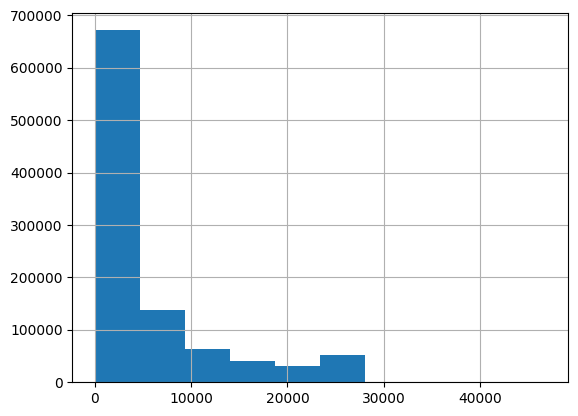

In [21]:
df.euclidean.hist()

In [22]:
stats = tfdv.generate_statistics_from_dataframe(
    dataframe=df,
    stats_options=tfdv.StatsOptions(
        label_feature='tip_bin',
        weight_feature=None,
        sample_rate=1,
        num_top_values=50
    )
)

In [23]:
tfdv.visualize_statistics(stats)

In [24]:
schema = tfdv.infer_schema(statistics=stats)
tfdv.display_schema(schema=schema)

,Type,Presence,Valency,Domain
Feature name,,,,
'trip_month',INT,required,,-
'trip_day',INT,required,,-
'trip_day_of_week',INT,required,,-
'trip_hour',INT,required,,-
'trip_seconds',INT,required,,-
'trip_miles',FLOAT,required,,-
'payment_type',STRING,required,,'payment_type'
'pickup_grid',STRING,required,,'pickup_grid'
'dropoff_grid',STRING,required,,'dropoff_grid'


,Values
Domain,
'payment_type',"'Cash', 'Credit Card', 'Dispute', 'Mobile', 'No Charge', 'Prcard', 'Prepaid', 'Unknown'"
'pickup_grid',"'POINT(-87.5 41.7)', 'POINT(-87.6 41.7)', 'POINT(-87.6 41.8)', 'POINT(-87.6 41.9)', 'POINT(-87.6 42)', 'POINT(-87.7 41.7)', 'POINT(-87.7 41.8)', 'POINT(-87.7 41.9)', 'POINT(-87.7 42)', 'POINT(-87.8 41.8)', 'POINT(-87.8 41.9)', 'POINT(-87.8 42)', 'POINT(-87.9 42)'"
'dropoff_grid',"'POINT(-87.5 41.7)', 'POINT(-87.6 41.7)', 'POINT(-87.6 41.8)', 'POINT(-87.6 41.9)', 'POINT(-87.6 42)', 'POINT(-87.7 41.7)', 'POINT(-87.7 41.8)', 'POINT(-87.7 41.9)', 'POINT(-87.7 42)', 'POINT(-87.8 41.8)', 'POINT(-87.8 41.9)', 'POINT(-87.8 42)', 'POINT(-87.9 42)'"
'community_name',"'Albany Park', 'Archer Heights', 'Armour Square', 'Ashburn', 'Auburn Gresham', 'Austin', 'Avalon Park', 'Avondale', 'Belmont Cragin', 'Beverly', 'Bridgeport', 'Brighton Park', 'Burnside', 'Calumet Heights', 'Chatham', 'Chicago Lawn', 'Clearing', 'Douglas', 'Dunning', 'East Garfield Park', 'East Side', 'Edgewater', 'Edison Park', 'Englewood', 'Forest Glen', 'Fuller Park', 'Gage Park', 'Garfield Ridge', 'Grand Boulevard', 'Greater Grand Crossing', 'Hegewisch', 'Hermosa', 'Humboldt Park', 'Hyde Park', 'Irving Park', 'Jefferson Park', 'Kenwood', 'Lake View', 'Lincoln Park', 'Lincoln Square', 'Logan Square', 'Loop', 'Lower West Side', 'McKinley Park', 'Montclare', 'Morgan Park', 'Mount Greenwood', 'Near North Side', 'Near South Side', 'Near West Side', 'New City', 'North Center', 'North Lawndale', 'North Park', 'Norwood Park', 'O\'Hare', 'Oakland', 'Portage Park', 'Pullman', 'Riverdale', 'Rogers Park', 'Roseland', 'South Chicago', 'South Deering', 'South Lawndale', 'South Shore', 'Uptown', 'Washington Heights', 'Washington Park', 'West Elsdon', 'West Englewood', 'West Garfield Park', 'West Lawn', 'West Pullman', 'West Ridge', 'West Town', 'Woodlawn'"


In [ ]:
raw_schema_location = os.path.join(RAW_SCHEMA_DIR, 'schema.pbtxt')
tfdv.write_schema_text(schema, raw_schema_location)

In [10]:
df['tip_percentage'] = (df['tips'] / df['fare']) * 100

# Create a binary target variable: 1 if tips > 20%, 0 otherwise
df['high_tip'] = np.where(df['tip_percentage'] > 20, 1, 0)


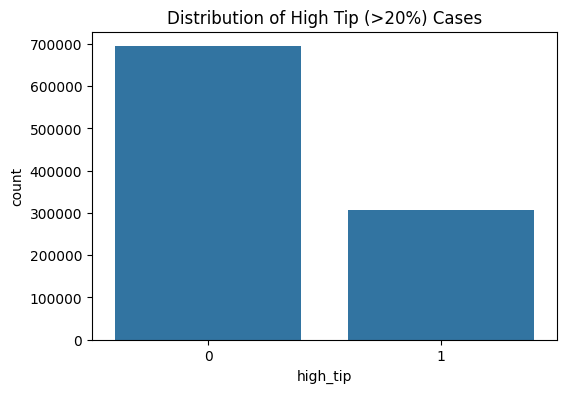

In [12]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='high_tip')
plt.title('Distribution of High Tip (>20%) Cases')
plt.show()


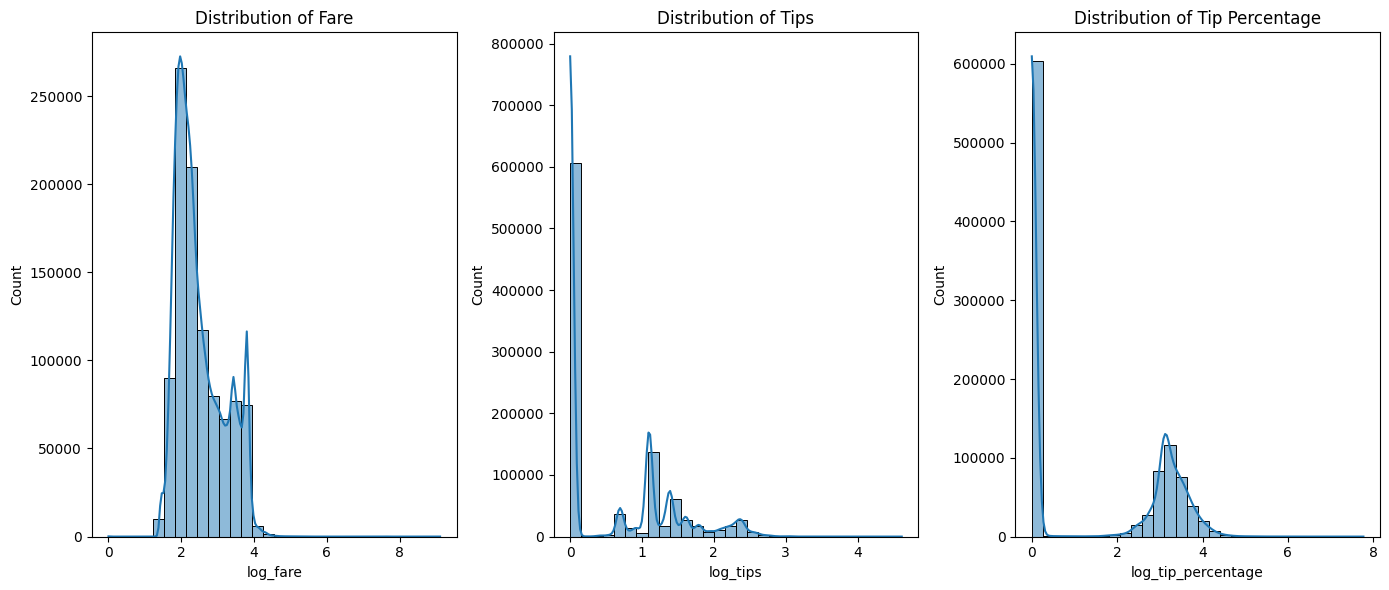

In [19]:
# Avoid taking log of zero or negative values by adding a small constant
df['log_fare'] = np.log1p(df['fare'])
df['log_tips'] = np.log1p(df['tips'])
df['log_tip_percentage'] = np.log1p(df['tip_percentage'])

plt.figure(figsize=(14, 6))

# Log-transformed Fare
plt.subplot(1, 3, 1)
sns.histplot(df['log_fare'], kde=True, bins=30)
plt.title('Distribution of Fare')

# Log-transformed Tips
plt.subplot(1, 3, 2)
sns.histplot(df['log_tips'], kde=True, bins=30)
plt.title('Distribution of Tips')

# Log-transformed Tip Percentage
plt.subplot(1, 3, 3)
sns.histplot(df['log_tip_percentage'], kde=True, bins=30)
plt.title('Distribution of Tip Percentage')

plt.tight_layout()
plt.show()


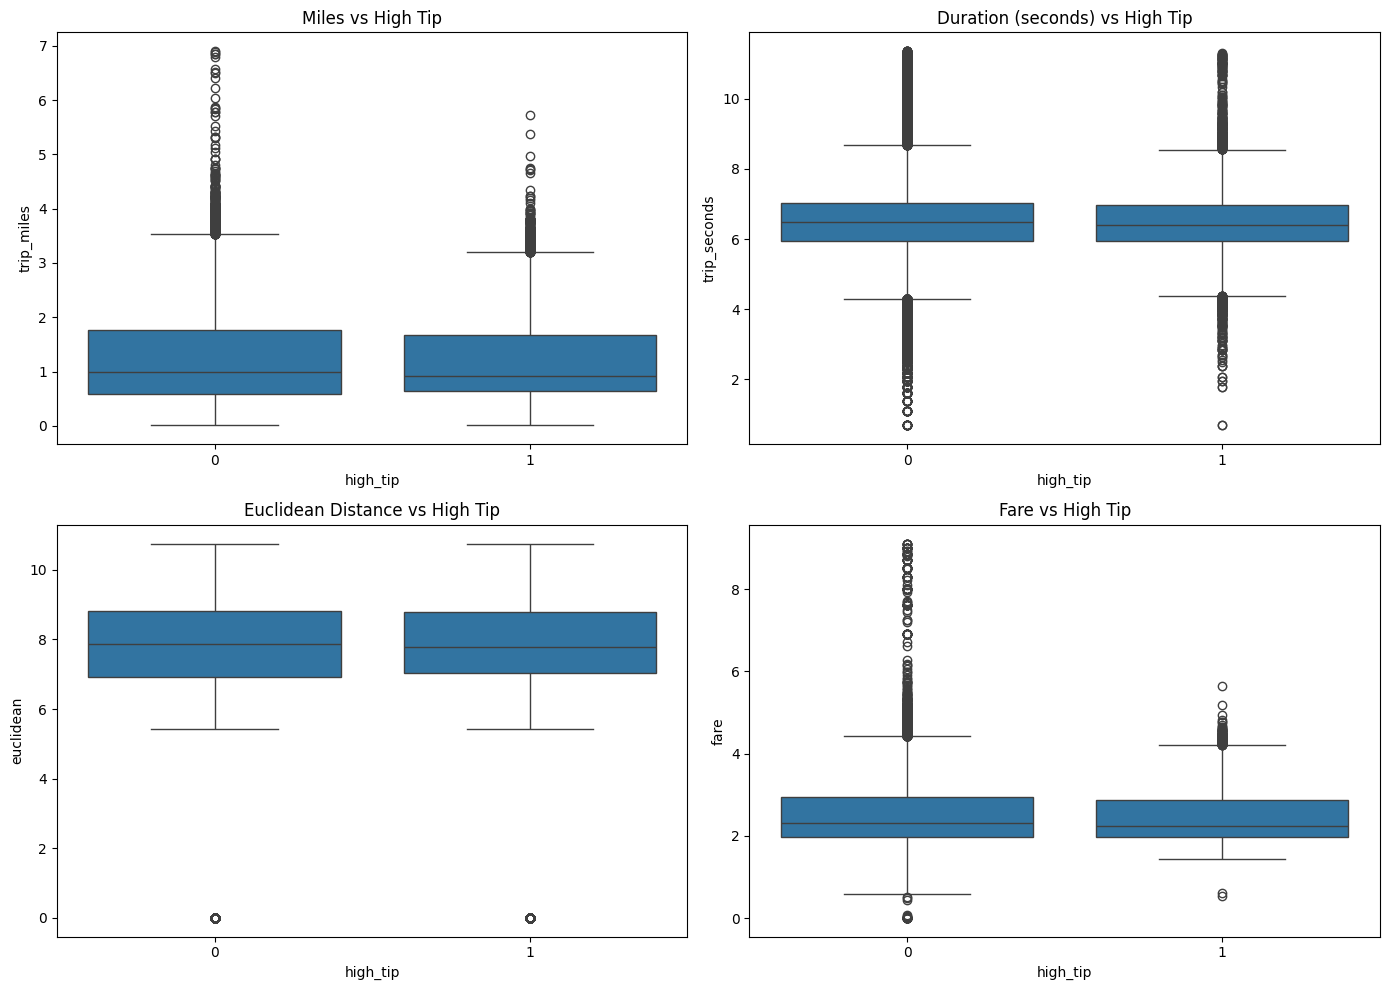

In [24]:
plt.figure(figsize=(14, 10))

# Log Trip Miles vs High Tip
plt.subplot(2, 2, 1)
sns.boxplot(data=df, x='high_tip', y=np.log1p(df['trip_miles']))
plt.title('Miles vs High Tip')

# Log Trip Duration (seconds) vs High Tip
plt.subplot(2, 2, 2)
sns.boxplot(data=df, x='high_tip', y=np.log1p(df['trip_seconds']))
plt.title('Duration (seconds) vs High Tip')

# Log Euclidean Distance vs High Tip
plt.subplot(2, 2, 3)
sns.boxplot(data=df, x='high_tip', y=np.log1p(df['euclidean']))
plt.title('Euclidean Distance vs High Tip')

# Log Fare vs High Tip
plt.subplot(2, 2, 4)
sns.boxplot(data=df, x='high_tip', y=np.log1p(df['fare']))
plt.title('Fare vs High Tip')

plt.tight_layout()
plt.show()


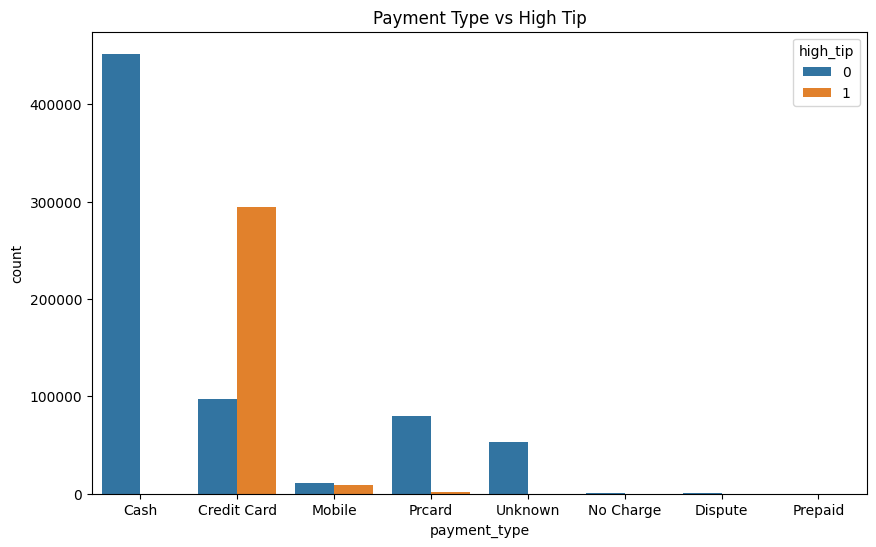

In [25]:
# Payment type vs High Tip
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='payment_type', hue='high_tip')
plt.title('Payment Type vs High Tip')
plt.show()

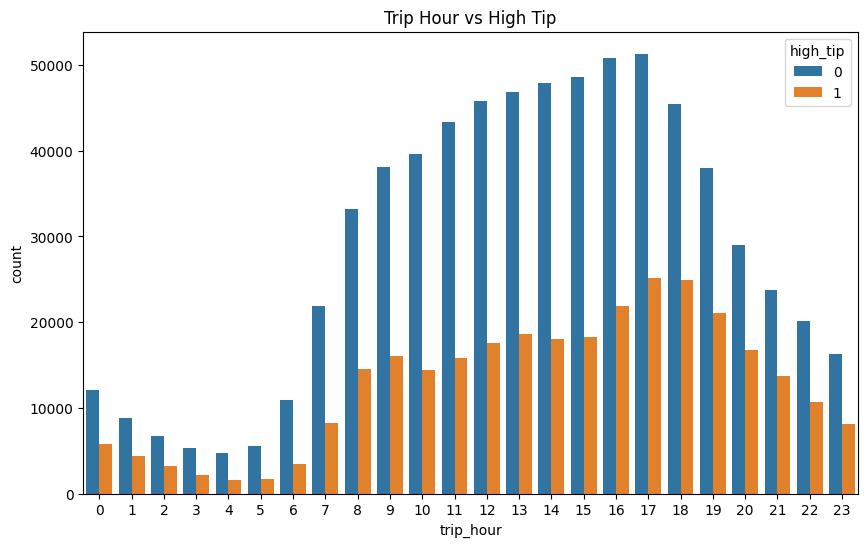

In [26]:
# Trip hour vs High Tip
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='trip_hour', hue='high_tip')
plt.title('Trip Hour vs High Tip')
plt.show()


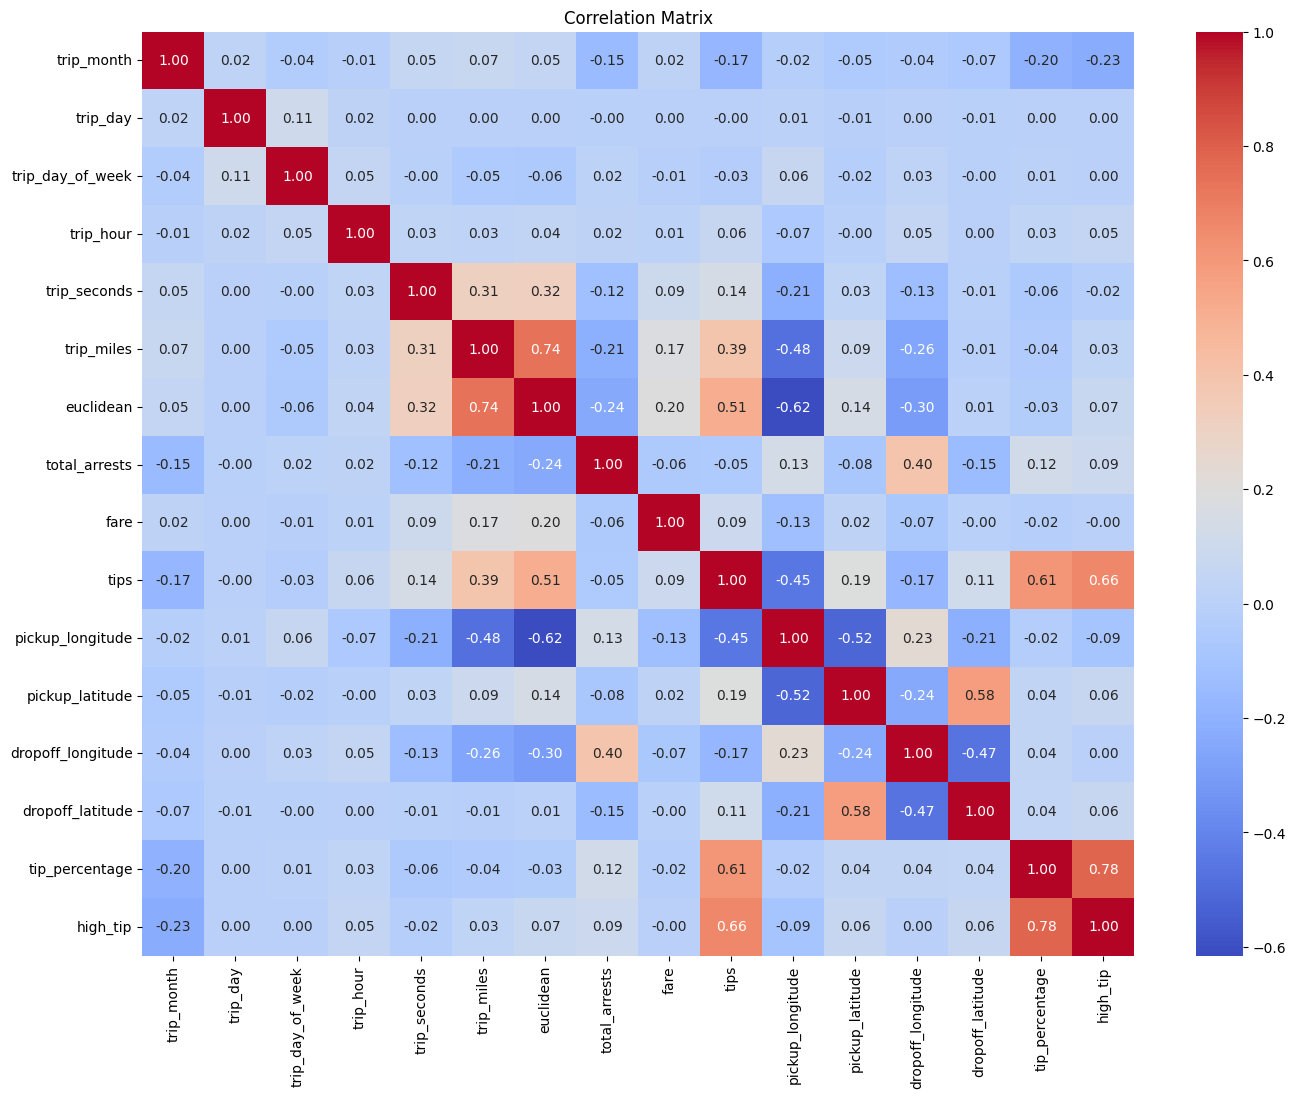

In [33]:
columns_to_include = [col for col in df.columns if 'log' not in col]

# Drop columns not in columns_to_include
df = df[columns_to_include]

# Plot the correlation matrix
plt.figure(figsize=(16, 12))
sns.heatmap(df, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

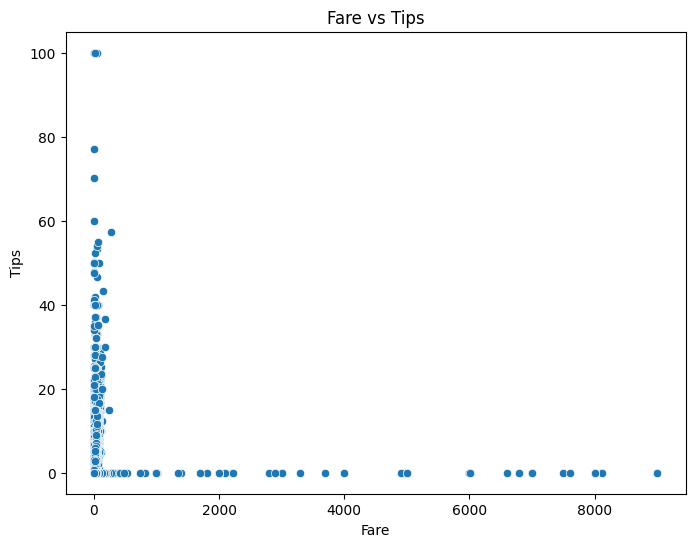

Percentage of tips > 20% of fare: 30.58%


In [17]:
_LABEL_KEY = 'tips'
_FARE_KEY = 'fare'

plt.figure(figsize=(8, 6))
sns.scatterplot(x=df[_FARE_KEY], y=df[_LABEL_KEY])
plt.title(f'Fare vs Tips')
plt.xlabel('Fare')
plt.ylabel('Tips')
plt.show()

# Check percentage of tips > 20% of fare
df['tip_percentage'] = (df[_LABEL_KEY] / df[_FARE_KEY]) * 100
high_tippers = df[df['tip_percentage'] > 20]

print(f"Percentage of tips > 20% of fare: {len(high_tippers) / len(df) * 100:.2f}%")

In [26]:
vertex_ai.init(
    project=PROJECT,
    location=REGION
)

In [27]:
bq_uri = f"bq://{PROJECT}.{BQ_DATASET_NAME}.{BQ_TABLE_NAME}"

dataset = vertex_ai.TabularDataset.create(
    display_name=DATASET_DISPLAY_NAME, bq_source=bq_uri)

dataset.gca_resource

Creating TabularDataset
Create TabularDataset backing LRO: projects/642238407820/locations/us-west2/datasets/2753071562834837504/operations/8367594649166020608
TabularDataset created. Resource name: projects/642238407820/locations/us-west2/datasets/2753071562834837504
To use this TabularDataset in another session:
ds = aiplatform.TabularDataset('projects/642238407820/locations/us-west2/datasets/2753071562834837504')


name: "projects/642238407820/locations/us-west2/datasets/2753071562834837504"
display_name: "chicago-taxi-tips"
metadata_schema_uri: "gs://google-cloud-aiplatform/schema/dataset/metadata/tabular_1.0.0.yaml"
create_time {
  seconds: 1722953775
  nanos: 493973000
}
update_time {
  seconds: 1722953776
  nanos: 868948000
}
etag: "AMEw9yPVZWA3jRFfZbD-fLYgCqfLReASN7a4rFYx8Td1egfjdJFZ2gvxIsL0No6q9ByX"
metadata {
  struct_value {
    fields {
      key: "inputConfig"
      value {
        struct_value {
          fields {
            key: "bigquerySource"
            value {
              struct_value {
                fields {
                  key: "uri"
                  value {
                    string_value: "bq://pa-poc-mlspec-1.playground.taxi_trips"
                  }
                }
              }
            }
          }
        }
      }
    }
  }
}
metadata_artifact: "projects/642238407820/locations/us-west2/metadataStores/default/artifacts/83279aac-f3ab-4b01-92c0-999ea2c1ca

In [28]:
dataset = vertex_ai.TabularDataset.list(
    filter=f"display_name={DATASET_DISPLAY_NAME}", 
    order_by="update_time")[-1]

print("Dataset resource name:", dataset.resource_name)
print("Dataset BigQuery source:", dataset.gca_resource.metadata['inputConfig']['bigquerySource']['uri'])

Dataset resource name: projects/642238407820/locations/us-west2/datasets/2753071562834837504
Dataset BigQuery source: bq://pa-poc-mlspec-1.playground.taxi_trips
